In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

class MNISTInfused(torch.utils.data.Dataset):
    def __init__(self, mnist_dataset, transform=None):
        self.mnist_dataset = mnist_dataset
        self.transform = transform

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        if self.transform:
            image = self.transform(image)
        features = extract_features(image)
        return (image, features), label


class CNNWithShallowInfusion(nn.Module):
    def __init__(self, feature_size):
        super(CNNWithShallowInfusion, self).__init__()
        # Define the CNN layers
        self.conv1 = nn.Conv2d(1, 16, 3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)

        # Define additional layers for the infused features
        self.fc_features = nn.Linear(feature_size, 128)
        self.fc_combined = nn.Linear(128 + 128, 10)

    def forward(self, x, features):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        
        features = torch.relu(self.fc_features(features))
        
        # Combine CNN output and shallow features
        combined = torch.cat((x, features), dim=1)
        combined = self.fc_combined(combined)
        return combined


# Check for GPU availability and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [8]:
def extract_features(image):
    # Assuming the input image is a PyTorch tensor of shape (1, 28, 28)
    image = image.squeeze(0)  # Remove channel dimension

    # Feature 1: Density
    density = torch.sum(image) / (28 * 28)  # Normalized density

    # Feature 2: Symmetry
    left_side = image[:, :14]
    right_side = image[:, 14:]
    flipped_right_side = torch.flip(right_side, [1])  # Flip the right side horizontally
    symmetry = torch.sum(torch.abs(left_side - flipped_right_side)) / (14 * 28)  # Normalized symmetry

    # Combine features into a single tensor
    features = torch.tensor([density, symmetry], dtype=torch.float32)
    return features


In [9]:
# Instantiate datasets
mnist_train = MNIST(root='./data', train=True, download=True, transform=ToTensor())
mnist_test = MNIST(root='./data', train=False, download=True, transform=ToTensor())

infused_train_dataset = MNISTInfused(mnist_train)
infused_test_dataset = MNISTInfused(mnist_test)

# Create DataLoaders
infused_train_loader = DataLoader(infused_train_dataset, batch_size=32, shuffle=True)
infused_test_loader = DataLoader(infused_test_dataset, batch_size=32, shuffle=False)

# Instantiate the model with the size of the feature vector
feature_size = 2  # Number of features extracted
cnn_infused_model = CNNWithShallowInfusion(feature_size).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_infused_model.parameters(), lr=0.001)

# Initialize lists to keep track of loss
train_losses = []
test_losses = []
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    cnn_infused_model.train()
    train_loss = 0
    for (images, features), labels in infused_train_loader:
        images, features, labels = images.to(device), features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn_infused_model(images, features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(infused_train_loader))

    cnn_infused_model.eval()
    test_loss = 0
    with torch.no_grad():
        for (images, features), labels in infused_test_loader:
            images, features, labels = images.to(device), features.to(device), labels.to(device)
            outputs = cnn_infused_model(images, features)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    test_losses.append(test_loss / len(infused_test_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')

    


Epoch [1/10], Train Loss: 0.1847, Test Loss: 0.0618
Epoch [2/10], Train Loss: 0.0536, Test Loss: 0.0358
Epoch [3/10], Train Loss: 0.0369, Test Loss: 0.0377
Epoch [4/10], Train Loss: 0.0272, Test Loss: 0.0372
Epoch [5/10], Train Loss: 0.0215, Test Loss: 0.0332
Epoch [6/10], Train Loss: 0.0172, Test Loss: 0.0313
Epoch [7/10], Train Loss: 0.0142, Test Loss: 0.0392
Epoch [8/10], Train Loss: 0.0114, Test Loss: 0.0319
Epoch [9/10], Train Loss: 0.0092, Test Loss: 0.0321
Epoch [10/10], Train Loss: 0.0085, Test Loss: 0.0442


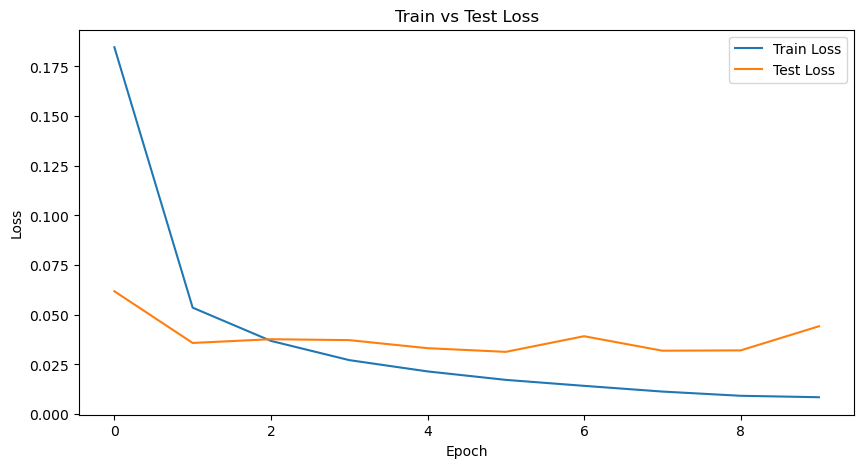

In [10]:
import matplotlib.pyplot as plt

# Plot the training and testing losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.show()

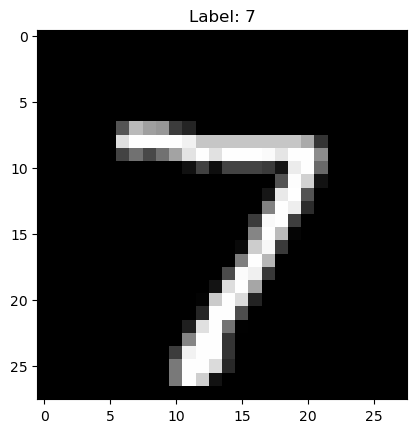

In [12]:
cnn_infused_model.eval()

# Get a single image and label from the test set for preview
single_data = next(iter(infused_test_loader))
((single_image, single_feature), single_label) = single_data
plt.imshow(single_image[0].squeeze(), cmap='gray')
plt.title(f'Label: {single_label[0].item()}')
plt.show()

In [14]:
single_image = single_image.to(device)
single_feature = single_feature.to(device)

# Make a prediction for this image
with torch.no_grad():
    output = cnn_infused_model(single_image, single_feature)
    _, predicted = torch.max(output.data, 1)
    print(f'Predicted: {predicted[0].item()}')


Predicted: 7


In [17]:
from sklearn.metrics import accuracy_score
# Calculate accuracy on the entire test set
all_labels = []
all_preds = []
with torch.no_grad():
    for (images, features), labels in infused_test_loader:
        images, features, labels = images.to(device), features.to(device), labels.to(device)
        outputs = cnn_infused_model(images, features)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
print(f'Accuracy: {accuracy_score(all_labels, all_preds):.4f}')

Accuracy: 0.9888


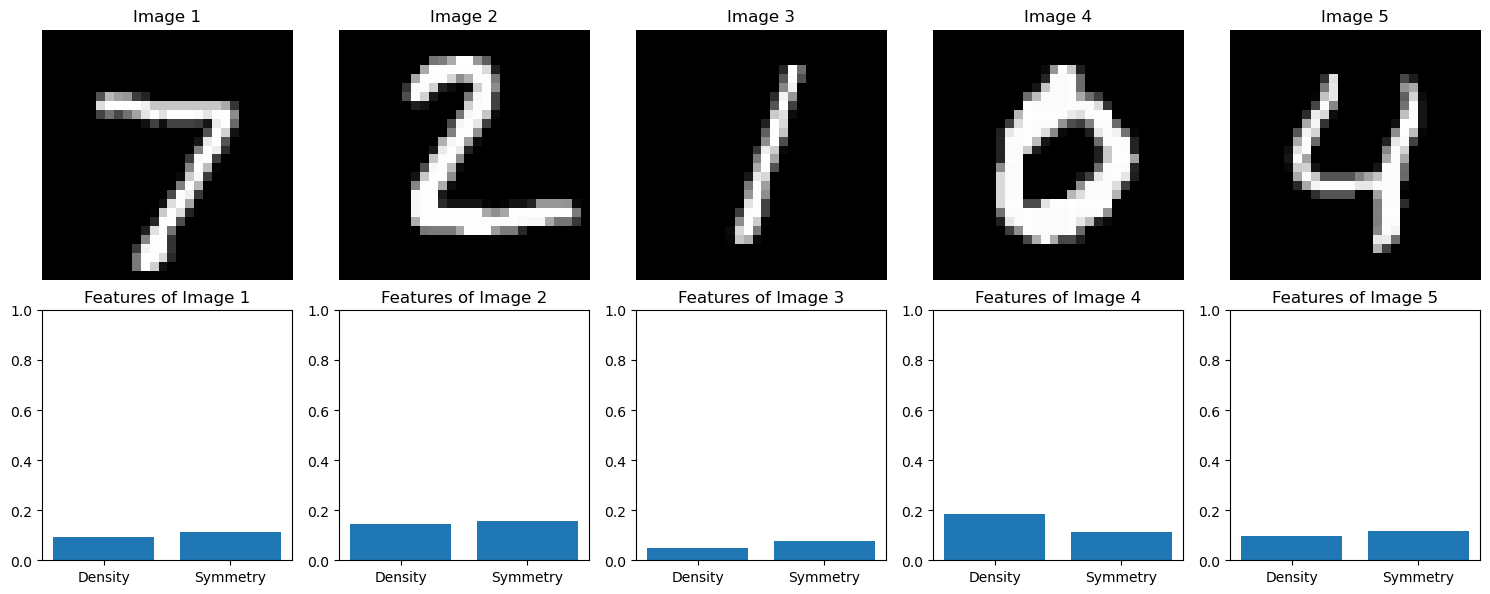

In [27]:
# Retrieve a few images and calculate their features
num_images = 5
densities = []
symmetries = []
images = []

for i in range(num_images):
    image, _ = mnist_test[i]
    images.append(image.squeeze().numpy())
    features = extract_features(image)
    densities.append(features[0].item())
    symmetries.append(features[1].item())

# Visualize the images and their features
fig, axs = plt.subplots(2, num_images, figsize=(15, 6))

for i in range(num_images):
    axs[0, i].imshow(images[i], cmap='gray')
    axs[0, i].set_title(f'Image {i+1}')
    axs[0, i].axis('off')

    axs[1, i].bar(['Density', 'Symmetry'], [densities[i], symmetries[i]])
    axs[1, i].set_ylim(0, 1)
    axs[1, i].set_title(f'Features of Image {i+1}')

plt.tight_layout()
plt.show()